In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

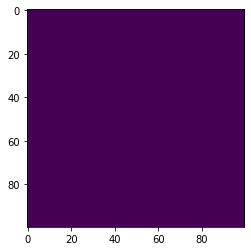

In [3]:
canvas = np.zeros((100,100))
plt.imshow(canvas, interpolation='none')
plt.show()

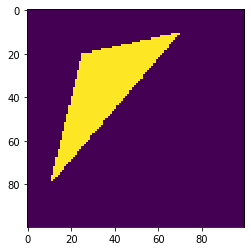

In [4]:
def draw_triangle(canvas, p1, p2, p3):
  '''
  http://www.sunshine2k.de/coding/java/TriangleRasterization/TriangleRasterization.html
  '''
  vs1 = p2 - p1
  vs2 = p3 - p1

  vs1_x_vs2 =  np.cross(vs1, vs2)

  stacked = np.stack([p1,p2,p3], axis=0)
  min_x, min_y = np.min(stacked, axis=0)
  max_x, max_y = np.max(stacked, axis=0)

  for x in range(min_x, max_x):
    for y in range(min_y, max_y):
      q = np.array([x, y]) - p1
      s = np.cross(q, vs2) /vs1_x_vs2
      t = np.cross(vs1, q) /vs1_x_vs2

      if s >= 0 and t >= 0 and s + t <=1:
        canvas[x][y] = 1

  return canvas

p1 = np.array([20,25], dtype=np.int32)
p2 = np.array([80,10], dtype=np.int32)
p3 = np.array([10,70], dtype=np.int32)

canvas = draw_triangle(canvas, p1, p2, p3)
plt.imshow(canvas, interpolation='none')
plt.show()

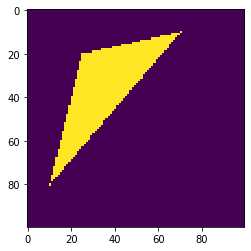

In [5]:
def draw_triangle(canvas, p1, p2, p3):
  '''
  http://www.sunshine2k.de/coding/java/TriangleRasterization/TriangleRasterization.html
  '''
  vs1 = p2 - p1
  vs2 = p3 - p1

  vs1_x_vs2 =  np.cross(vs1, vs2)

  xs = np.arange(canvas.shape[0])
  ys = np.arange(canvas.shape[1])

  xs_tiled = np.tile(np.expand_dims(xs, 1), [1, ys.shape[0]])
  xs_tiled = np.expand_dims(xs_tiled, 2)
  ys_tiled = np.tile(np.expand_dims(ys, 0), [xs.shape[0], 1])
  ys_tiled = np.expand_dims(ys_tiled, 2)
  cartesian_product = np.concatenate([xs_tiled, ys_tiled], axis=2)

  q = cartesian_product - p1

  vs1 = np.tile(vs1, [xs.shape[0], ys.shape[0], 1])
  vs2 = np.tile(vs2, [xs.shape[0], ys.shape[0], 1])

  s = np.cross(q, vs2, axis=-1) / vs1_x_vs2
  t = np.cross(vs1, q, axis=-1) / vs1_x_vs2

  sg0 = s >= 0
  tg0 = t >= 0
  stl1 = s + t <= 1
  canvas = sg0 * tg0 * stl1

  return canvas

p1 = np.array([20,25], dtype=np.float32)
p2 = np.array([80,10], dtype=np.float32)
p3 = np.array([10,70], dtype=np.float32)
canvas = np.zeros((100,100), dtype=np.float32)
canvas = draw_triangle(canvas, p1, p2, p3)
plt.imshow(canvas, interpolation='none')
plt.show()

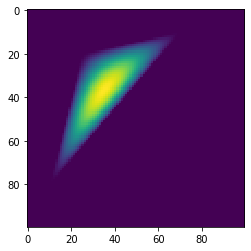

In [6]:
@tf.function
def draw_triangle(canvas, p1, p2, p3):
  '''
  http://www.sunshine2k.de/coding/java/TriangleRasterization/TriangleRasterization.html
  '''
  a_zero = tf.constant([0], dtype=tf.float32)
  p1 = tf.concat([p1, a_zero], axis=0)
  p2 = tf.concat([p2, a_zero], axis=0)
  p3 = tf.concat([p3, a_zero], axis=0)

  vs1 = p2 - p1
  vs2 = p3 - p1

  vs1_x_vs2 = tf.linalg.cross(vs1, vs2)
  vs1_x_vs2 = tf.reduce_sum(vs1_x_vs2)

  xs = tf.range(canvas.shape[0])
  ys = tf.range(canvas.shape[1])

  xs_tiled = tf.tile(tf.expand_dims(xs, 1), [1, ys.shape[0]])
  xs_tiled = tf.expand_dims(xs_tiled, 2)
  ys_tiled = tf.tile(tf.expand_dims(ys, 0), [xs.shape[0], 1])
  ys_tiled = tf.expand_dims(ys_tiled, 2)
  zeros = tf.zeros([xs.shape[0], ys.shape[0], 1], dtype=tf.int32)
  cartesian_product = tf.concat([xs_tiled, ys_tiled, zeros], axis=2)
  cartesian_product = tf.cast(cartesian_product, dtype=tf.float32)

  q = cartesian_product - p1

  vs1 = tf.reshape(vs1, [1,1,3])
  vs1 = tf.tile(vs1, [xs.shape[0], ys.shape[0], 1])
  vs2 = tf.reshape(vs2, [1,1,3])
  vs2 = tf.tile(vs2, [xs.shape[0], ys.shape[0], 1])

  s = tf.reduce_sum(tf.linalg.cross(q, vs2), axis=-1) / vs1_x_vs2
  t = tf.reduce_sum(tf.linalg.cross(vs1, q), axis=-1) / vs1_x_vs2

  sg0 = tf.nn.relu(s) # s >= 0
  tg0 = tf.nn.relu(t) # t >= 0
  stl1 = tf.nn.relu(-(s + t - 1)) # s + t <= 1
  result = sg0 * tg0 * stl1

  return result

p1 = tf.constant([20,25], dtype=tf.float32)
p2 = tf.constant([80,10], dtype=tf.float32)
p3 = tf.constant([10,70], dtype=tf.float32)
canvas = tf.zeros((100,100), dtype=tf.float32)
canvas = draw_triangle(canvas, p1, p2, p3)
plt.imshow(canvas, interpolation='none')
plt.show()

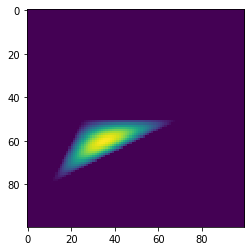

In [7]:
p1 = tf.constant([50,25], dtype=tf.float32)
p2 = tf.constant([80,10], dtype=tf.float32)
p3 = tf.constant([50,70], dtype=tf.float32)
target_canvas = tf.zeros((100,100), dtype=tf.float32)
target_canvas = draw_triangle(target_canvas, p1, p2, p3)
plt.imshow(target_canvas, interpolation='none')
plt.show()

In [8]:
p1 = tf.Variable([20,25], dtype=tf.float32)
p2 = tf.Variable([80,10], dtype=tf.float32)
p3 = tf.Variable([10,70], dtype=tf.float32)
canvas = tf.Variable(tf.zeros((100,100), dtype=tf.float32))
with tf.GradientTape(persistent=True) as tape:
  canvas = draw_triangle(canvas, p1, p2, p3)
  loss = tf.nn.l2_loss(target_canvas - canvas)

dp1 = tape.gradient(loss, p1)
dp2 = tape.gradient(loss, p2)
dp3 = tape.gradient(loss, p3)
print(dp1, dp2, dp3)

tf.Tensor([-0.00622854 -0.0071758 ], shape=(2,), dtype=float32) tf.Tensor([ 0.00106911 -0.00237593], shape=(2,), dtype=float32) tf.Tensor([0.00026887 0.00469822], shape=(2,), dtype=float32)


In [11]:
tp1 = tf.constant([50,25], dtype=tf.float32)
tp2 = tf.constant([80,10], dtype=tf.float32)
tp3 = tf.constant([50,70], dtype=tf.float32)
target_canvas = tf.zeros((100,100), dtype=tf.float32)
target_canvas = draw_triangle(target_canvas, tp1, tp2, tp3)

p1 = tf.Variable([20,25], dtype=tf.float32)
p2 = tf.Variable([80,50], dtype=tf.float32)
p3 = tf.Variable([10,70], dtype=tf.float32)
sp1, sp2, sp3 = tf.constant(p1), tf.constant(p2), tf.constant(p3)
canvas = tf.Variable(tf.zeros((100,100), dtype=tf.float32))

# opt = tf.keras.optimizers.Adam(learning_rate=3e-4)
# opt = tf.keras.optimizers.Adam(learning_rate=1e-1)
opt = tf.keras.optimizers.SGD(learning_rate=1e-0)

@tf.function
def actual_loss():
  dp1 = tf.nn.l2_loss(p1 - tp1)
  dp2 = tf.nn.l2_loss(p2 - tp2)
  dp3 = tf.nn.l2_loss(p3 - tp3)

  # return (dp1 + dp2 + dp3) / 1e+6
  return (dp1 + dp2 + dp3)

@tf.function
def train_step():
  with tf.GradientTape() as tape:
    c = draw_triangle(canvas, p1, p2, p3)
    loss = tf.nn.l2_loss(target_canvas - c)
  g1, g2, g3 = tape.gradient(loss, [p1, p2, p3])
  opt.apply_gradients(zip([g1,g2,g3], [p1,p2,p3]))

  return loss

@tf.function
def float_pretty(t):
  t = t * 100
  t = tf.round(t)
  t = t / 100
  return t

for i in range(100000):
  loss = train_step()
  if i % 10000 == 0:
    tf.print(i, float_pretty(loss), float_pretty(actual_loss()))

tf.print(float_pretty(sp1), float_pretty(p1), float_pretty(tp1))
tf.print(float_pretty(sp2), float_pretty(p2), float_pretty(tp2))
tf.print(float_pretty(sp3), float_pretty(p3), float_pretty(tp3))

0 0.38 2049.97
10000 0.299999982 1783.28992
20000 0.24 1634.2
30000 0.199999988 1582.9
40000 0.16 1586.17993
50000 0.14 1659.19
60000 0.14 1657.22
70000 0.14 1654.2
80000 0.14 1651.2
90000 0.14 1648.2
[20 25] [30.05 46.6499977] [50 25]
[80 50] [78.0099945 39.34] [80 10]
[10 70] [16.46 49.17] [50 70]


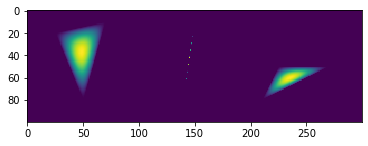

In [12]:
start_canvas = tf.zeros((100,100), dtype=tf.float32)
start_canvas = draw_triangle(start_canvas, sp1, sp2, sp3)

current_canvas = tf.zeros((100,100), dtype=tf.float32)
current_canvas = draw_triangle(current_canvas, p1, p2, p3)

target_canvas = tf.zeros((100,100), dtype=tf.float32)
target_canvas = draw_triangle(target_canvas, tp1, tp2, tp3)

stacked = np.hstack([start_canvas.numpy(), current_canvas.numpy(), target_canvas.numpy()])
plt.imshow(stacked, interpolation='none')
plt.show()